# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

<b>Заказчику важны:</b>

- качество предсказания;
- скорость предсказания;
- время обучения.

В данной работе мы построим, обучим и протестируем метрикой RMSE несколько моделей: LightGBM, CatBoost и линейную регрессию.

<b>Признаки</b>
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

<b>Целевой признак</b>
- Price — цена (евро)

## Подготовка данных

### Импорты и настройки

In [1]:
!pip install -q catboost
!pip install -q lightgbm
!pip install scikit-learn==1.1.3 -q

In [2]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import re

from catboost import Pool, CatBoostRegressor
from numpy.random import RandomState
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [3]:
# Сделаем настройки

# Зададим формат отображения вещественных чисел в Pandas
pd.set_option('display.float_format', '{:,.2f}'.format)

# Сбросим ограничение на число столбцов
pd.set_option('display.max_columns', None)

# Сбросим ограничение на число строк
pd.set_option('display.max_rows', None)

# Не показываем предупреждения
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

# Зададим константу для генератора псевдослучайных чисел
RANDOM_STATE = 42

# Зададим значение для генератора псевдослучайных чисел
np.random.seed(RANDOM_STATE)
STATE = RandomState(RANDOM_STATE)

### Загрузка и обзор данных

Сразу приведем к формату datetime признаки содержащие дату.

In [4]:
try:
    df = pd.read_csv('/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
except:
    df = pd.read_csv('autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

In [5]:
# сохраним в переменную размер таблицы
df_old_shape = df.shape

df_old_shape

(354369, 16)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

In [7]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


Напишем функцию для обзора данных.

In [8]:
def dataframe_information(data):
    """Функция для вывода основных статистик набора данных"""
    df_data = []
    df_cols = ['name', 'object', 'na', 'zero', 'rate', 'unique', 'neg',
               'mean', 'std', 'min', 'max', 'outliners', 'duplicates']
    # перебираем столбцы в наборе данных
    for column_name in data.columns:
        column_negative_values, column_mean, column_std, column_min, column_max, outliers, duplicates_sum = \
            None, None, None, None, None, None, None
        # считаем характеристики
        column_type = data[column_name].dtypes
        column_na_values = data[column_name].isna().sum()
        column_zero_values = data[column_name][data[column_name] == 0].count()
        column_na_zero_rate = ((column_na_values + column_zero_values) / data.shape[0]) * 100
        column_unique_values = len(data[column_name].unique())
        duplicates_sum = len(data.loc[data.duplicated() > 0, column_name])
        if column_type not in ['object', 'datetime64[ns]']:
            column_negative_values = data[column_name][data[column_name] < 0].count()
            column_mean = data[column_name].mean()
            column_std = data[column_name].std()
            column_min = data[column_name].min()
            column_max = data[column_name].max()
            q1 = data[column_name].quantile(0.25)
            q3 = data[column_name].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            outliers = len(data[(data[column_name] < lower_bound) | (data[column_name] > upper_bound)])

        # собираем показатели по каждому полю
        df_data.append([column_name, column_type, column_na_values,
                        column_zero_values, column_na_zero_rate, column_unique_values,
                        column_negative_values, column_mean, column_std,
                        column_min, column_max, outliers, duplicates_sum])

    # формируем набор данных
    df_res = pd.DataFrame(data=df_data, columns=df_cols)

    return df_res


# Применим функцию на датафрейм
dataframe_information(df)

,name,object,na,zero,rate,unique,neg,mean,std,min,max,outliners,duplicates
0,DateCrawled,datetime64[ns],0,0,0.00,271174,NaN,NaN,NaN,NaN,NaN,NaN,4
1,Price,int64,0,10772,3.04,3731,0.00,"4,416.66","4,514.16",0.00,"20,000.00","18,979.00",4
2,VehicleType,object,37490,0,10.58,9,NaN,NaN,NaN,NaN,NaN,NaN,4
3,RegistrationYear,int64,0,0,0.00,151,0.00,"2,004.23",90.23,"1,000.00","9,999.00","6,309.00",4
4,Gearbox,object,19833,0,5.60,3,NaN,NaN,NaN,NaN,NaN,NaN,4
5,Power,int64,0,40225,11.35,712,0.00,110.09,189.85,0.00,"20,000.00","7,340.00",4
6,Model,object,19705,0,5.56,251,NaN,NaN,NaN,NaN,NaN,NaN,4
7,Kilometer,int64,0,0,0.00,13,0.00,"128,211.17","37,905.34","5,000.00","150,000.00","53,257.00",4
8,RegistrationMonth,int64,0,37352,10.54,13,0.00,5.71,3.73,0.00,12.00,0.00,4
9,FuelType,object,32895,0,9.28,8,NaN,NaN,NaN,NaN,NaN,NaN,4


In [9]:
# оценим корреляццию признаков
df.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.00,0.03,0.16,-0.33,0.11,NaN,0.08
RegistrationYear,0.03,1.00,-0.00,-0.05,-0.01,NaN,-0.00
Power,0.16,-0.00,1.00,0.02,0.04,NaN,0.02
Kilometer,-0.33,-0.05,0.02,1.00,0.01,NaN,-0.01
RegistrationMonth,0.11,-0.01,0.04,0.01,1.00,NaN,0.01
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.08,-0.00,0.02,-0.01,0.01,NaN,1.00


Кореляция крайне низкая, вероятно это из-за большого количества аномалий.

Проверим, за какой период нам предоставлена выборка.

In [13]:
pd.DatetimeIndex(df['DateCreated']).year.value_counts()

2016    354343
2015        25
2014         1
Name: DateCreated, dtype: int64

Данные имеют следующие проблемы:
1. Для обучения модели нам нужны актуальные данные, поэтому удалим случаи, в которых дата создания анкеты машины меньше 2016 года, как мы выяснили ранее таких случаев всего 26.
2. Repaired (была ли машина в ремонте) имеет 20% пропусков. В целом, учитывая пропорции распределения значений

In [14]:
# распределение значений в Repaired
df['Repaired'].value_counts(normalize=True)

no    0.87
yes   0.13
Name: Repaired, dtype: float64

... можно бы было заполнить модой, но учитывая (если логически рассуждать), что эта переменная довольно важна для прогнозирования целевого признака и пропуски также влияют на рыночную стоимость автомобиля, заполним эти пропуски новой категориальной переменной - 'unknown', таким образом сохранив информацию о пропусках.

3. В колонках Gearbox, VehicleType, Model и FuelType также есть пропуски от 5% до 10%, колонки категориальные, поэтому также заполним их значением 'unknown'.
4. В данных 4 дубликата, удалим их.
5. В колонке Power есть аномально высокие значения и ~11% нулевых, слишком много для заполнения медианой, это сильно исказит данные, попробуем восстановить часть значений по нескольким колонкам - модели, типу кузова, году регистрации, возьмем также медиану, это снизит искажение. Остальные случаи удалим, так как такие случаи содержат значительное количество пропусков и аномалии, что говорит о их нерепрезентативности:

In [15]:
# посмотрим пропуски в других колонках у строк с аномальными значениями в Power
df[(df['Power'] == 0) | (df['Power'] > 500)].isna().sum()

DateCrawled              0
Price                    0
VehicleType          14701
RegistrationYear         0
Gearbox              13339
Power                    0
Model                 6352
Kilometer                0
RegistrationMonth        0
FuelType             11759
Brand                    0
Repaired             21576
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [16]:
# аномалии даты регистрации автомобиля
len(df[(df['Power'] == 0) | (df['Power'] > 500)]
    [(df['RegistrationYear'] < 1940) | 
     (df['RegistrationYear'] > pd.DatetimeIndex(df['LastSeen']).year)]
)

3930

In [17]:
# всего аномалий даты регистрации автомобиля
len(df[(df['RegistrationYear'] < 1940) | (df['RegistrationYear'] > pd.DatetimeIndex(df['LastSeen']).year)])

14752

In [18]:
# распределение аномалий в колонке Power по моделям
df[(df['Power'] == 0) | (df['Power'] > 500)]['Model'].value_counts()

other                3208
golf                 2485
corsa                1786
polo                 1627
3er                  1551
astra                1125
twingo                962
passat                895
c_klasse              751
a4                    736
fiesta                731
e_klasse              653
a_klasse              544
focus                 544
ka                    539
vectra                533
clio                  525
punto                 523
5er                   511
transporter           505
a3                    494
mondeo                437
fortwo                426
megane                400
a6                    369
touran                365
zafira                359
3_reihe               348
lupo                  335
2_reihe               323
micra                 304
sharan                231
scenic                220
80                    215
ibiza                 208
caddy                 191
kangoo                184
laguna                184
601         

In [19]:
# представленность моделей в целом
df['Model'].value_counts()

golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
astra                 10809
passat                10146
a4                     9900
c_klasse               8312
5er                    7868
e_klasse               6785
a3                     6122
focus                  5874
fiesta                 5774
a6                     5541
twingo                 4953
transporter            4822
2_reihe                4816
fortwo                 4337
vectra                 4254
a_klasse               4193
mondeo                 3601
clio                   3546
1er                    3514
3_reihe                3493
touran                 3470
punto                  3347
zafira                 3044
megane                 2910
ka                     2702
ibiza                  2702
lupo                   2594
octavia                2108
fabia                  2080
cooper                 1950
clk                 

Мы берем ограничение в 500 лошадиных сил потому, что максимальная цена в выборке - 20 тыс евро.

In [20]:
# посмотрим количество случаев с мощностью более 500 лошадей.
len(df[df['Power'] > 500])

459

6. Колонка RegistrationYear содержит аномалии - год регистрации автомобиля от 1000 до 9999, как мы выяснили раннее, таких случаев 14699, причем большая часть таких случаев - регистрация на 2017 год:

In [21]:
len(df[df['RegistrationYear'] == 2017])

10441

In [22]:
# выведем месяц регистрации у таких случаев
df[df['RegistrationYear'] == 2017]['RegistrationMonth'].value_counts()

0     2717
6      818
3      806
4      746
5      740
7      695
12     625
10     624
8      585
11     560
9      524
1      508
2      493
Name: RegistrationMonth, dtype: int64

In [23]:
# проверим пробег таких случаев
df[df['RegistrationYear'] == 2017]['Kilometer'].value_counts()

150000    7758
125000    1001
100000     305
5000       257
90000      253
80000      195
70000      157
60000      123
50000      111
20000      111
30000       87
40000       59
10000       24
Name: Kilometer, dtype: int64

Год регистрации это показатель того, насколько долго машина находится в эксплуатации, поэтому нам очень важен данный показатель, он должен хорошо коррелиировать с целевым признаком. Попробуем восстановить часть значений, взяв моду наиболее часто встречающегося значения на основании модели, кузова и типа коробки передач. Что не получиться восстановить - удалим.

7. Колонки DateCrawled, LastSeen, PostalCode, DateCreated, NumberOfPictures и RegistrationMonth не нужны для обучения модели, поэтому также их удалим. Стоит обратить внимание, что в колонке RegistrationMonth обнаружена аномалия - в году 13 месяцев, т.к. присутствует нулевой месяц, рекомендуется разобраться с причиной появления аномалии.

8. В колонке Price ~3% нулевых значений, это целевой признак, поэтому просто удалим эти случаи. Проверим распределение значений в этой колонке:

<AxesSubplot:>

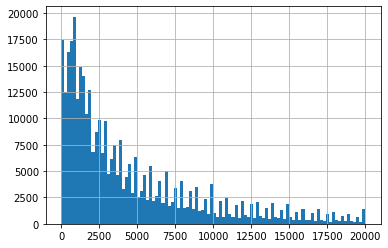

In [24]:
df['Price'].hist(bins=100)

In [25]:
# Посмотрим количество случаев с ценой меньше 100 евро.
len(df[(df['Price'] < 100) & (df['Price'] > 0)])

2542

In [26]:
# посмотрим на эти случаи
df[(df['Price'] < 100) & (df['Price'] > 0)].head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
59,2016-03-29 15:48:15,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29,0,53721,2016-04-06 01:44:38
89,2016-03-28 09:37:01,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no,2016-03-28,0,40589,2016-04-06 12:15:54
268,2016-03-12 07:26:49,1,sedan,1990,manual,90,80,70000,6,petrol,audi,no,2016-03-11,0,55122,2016-03-26 23:15:49
408,2016-03-29 18:51:58,1,NaN,2000,NaN,75,golf,90000,3,petrol,volkswagen,NaN,2016-03-29,0,78588,2016-04-06 04:45:50
552,2016-03-21 10:52:52,50,NaN,1985,NaN,0,NaN,150000,11,NaN,trabant,NaN,2016-03-21,0,69120,2016-03-22 14:50:41
901,2016-03-06 00:25:25,1,NaN,1990,manual,0,other,150000,0,NaN,porsche,NaN,2016-03-05,0,65843,2016-04-06 20:19:08
943,2016-04-03 14:39:43,98,small,1997,manual,53,swift,150000,7,petrol,suzuki,no,2016-04-03,0,14542,2016-04-05 13:18:15
967,2016-03-23 08:21:11,1,wagon,1998,manual,136,omega,150000,0,petrol,opel,no,2016-03-22,0,57614,2016-03-27 08:45:52
1025,2016-03-15 18:57:12,3,convertible,1998,manual,110,mx_reihe,150000,11,NaN,mazda,yes,2016-03-15,0,89312,2016-04-06 21:16:58
1076,2016-03-18 07:53:24,45,NaN,2015,NaN,0,other,5000,0,NaN,mini,NaN,2016-03-18,0,37339,2016-04-05 22:15:28


Как видим, здесь либо побывавшие в ремонте (возможно неподлежащие восстановлению), либо старенькие машины с максимально возможным для указания пробегом (150 тыс., недальновидное ограничение, это искажает статистику). Последние возможно хотят отдать даром, чтобы не тратить средства на утилизацию.
Также возможно некоторые клиенты ставили цену в тысячах долларов, отсеять такие случаи мы не сможем. 

Заказчику нужна модель для привлечения новых клиентов, поэтому удалим случаи с ценой менее 100 долларов, чтобы потенциальным клиентам не предсказывалась слишком низкая цена из-за явного утиля и аномалий. 

In [27]:
df[df['Power'] > 500].head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1816,2016-03-22 20:52:00,3200,small,2004,manual,1398,corolla,5000,6,petrol,toyota,no,2016-03-22,0,22043,2016-03-22 21:43:26
2102,2016-03-21 11:55:22,0,sedan,1999,NaN,1799,vectra,150000,1,petrol,opel,yes,2016-03-21,0,1723,2016-04-04 04:49:06
3746,2016-03-21 14:48:31,0,NaN,2017,manual,750,NaN,150000,8,petrol,smart,no,2016-03-21,0,49356,2016-03-24 03:44:59
4060,2016-04-03 20:31:00,3100,sedan,2005,manual,953,colt,150000,4,gasoline,mitsubishi,no,2016-04-03,0,60326,2016-04-07 14:56:46
5328,2016-03-29 19:44:48,500,wagon,1999,manual,1001,astra,150000,7,petrol,opel,NaN,2016-03-29,0,33154,2016-04-06 05:44:36
6296,2016-03-31 23:50:47,599,small,2002,manual,603,matiz,5000,11,petrol,chevrolet,yes,2016-03-31,0,44379,2016-04-01 03:41:52
6504,2016-03-14 15:54:34,3000,small,2009,manual,771,punto,125000,0,petrol,fiat,NaN,2016-03-14,0,40721,2016-03-14 15:54:34
6637,2016-03-31 19:48:22,600,small,1996,manual,603,corsa,150000,8,petrol,opel,yes,2016-03-31,0,70327,2016-04-06 14:17:51
7661,2016-04-02 19:25:25,1499,small,1999,manual,7515,lupo,150000,4,petrol,volkswagen,NaN,2016-04-02,0,65830,2016-04-06 11:46:49
7720,2016-04-02 11:48:54,1500,small,2000,manual,1400,NaN,150000,0,petrol,honda,NaN,2016-04-02,0,21509,2016-04-04 09:15:26


### Предобработка данных

#### Удалим неактуальные данные

In [28]:
df = df[pd.DatetimeIndex(df['DateCreated']).year == 2016]

# проверим
df.shape

(354343, 16)

#### Обработка дубликатов

In [29]:
# удалим полные дубликаты
df = df.drop_duplicates()

df.shape

(354339, 16)

In [30]:
# проверим наличие неявных дубликатов
df.drop('Price', axis=1).duplicated().sum()

1

In [31]:
# удалим дубликат
df = df[~df.drop('Price', axis=1).duplicated()]

df.shape

(354338, 16)

#### Удалим колонки

In [32]:
df = df.drop(
    ['NumberOfPictures', 'DateCrawled', 'LastSeen', 'PostalCode',
     'DateCreated', 'RegistrationMonth'], axis=1
)

# проверим
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354338 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354338 non-null  int64 
 1   VehicleType       316850 non-null  object
 2   RegistrationYear  354338 non-null  int64 
 3   Gearbox           334507 non-null  object
 4   Power             354338 non-null  int64 
 5   Model             334634 non-null  object
 6   Kilometer         354338 non-null  int64 
 7   FuelType          321443 non-null  object
 8   Brand             354338 non-null  object
 9   Repaired          283188 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


#### Обработка аномалий в Power

In [33]:
# заменим аномалии на NaN
df.loc[(df['Power'] == 0) | (df['Power'] > 500), 'Power'] = np.nan

# оценим результат
df.isna().sum()

Price                   0
VehicleType         37488
RegistrationYear        0
Gearbox             19831
Power               40682
Model               19704
Kilometer               0
FuelType            32895
Brand                   0
Repaired            71150
dtype: int64

In [34]:
# заполним пропуски там, где это возможно
df['Power'] = (df['Power'].fillna(df.groupby(['Brand', 'Model', 'RegistrationYear', 'FuelType', 'VehicleType'])['Power']
                                    .transform('median')))
# посмотрим сколько нам не удалось заполнить
df.isna().sum()

Price                   0
VehicleType         37488
RegistrationYear        0
Gearbox             19831
Power               21653
Model               19704
Kilometer               0
FuelType            32895
Brand                   0
Repaired            71150
dtype: int64

In [35]:
# удалим случаи, в которых нам не удалось заполнить пропуски
df = df.dropna(subset=['Power'])

# оценим результат
df.isna().sum()

Price                   0
VehicleType         22788
RegistrationYear        0
Gearbox             10087
Power                   0
Model               13352
Kilometer               0
FuelType            21136
Brand                   0
Repaired            57420
dtype: int64

Стоит обратить внимание на то, как сильно уменьшилось количество пропусков в других колонках. Это говорит о том, что мы удалили строки, где половина информации была пропущена. 

#### Обработка аномалий в RegistrationYear

In [36]:
# оценим количество выбросов ниже нижней границы
len(df[df['RegistrationYear'] < 1940])

45

In [37]:
# заменим аномалии на NaN
df.loc[(df['RegistrationYear'] < 1940) | (df['RegistrationYear'] > 2016), 'RegistrationYear'] = np.nan

# оценим результат
df.isna().sum()

Price                   0
VehicleType         22788
RegistrationYear    10823
Gearbox             10087
Power                   0
Model               13352
Kilometer               0
FuelType            21136
Brand                   0
Repaired            57420
dtype: int64

In [38]:
# желалось заполнить модой, но юпитер на платформе выдает ошибку, 
# хотя на локальном юпитере операция выполняется нормально 
# (.transform(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else np.nan))
df['RegistrationYear'] = (df['RegistrationYear']
                          .fillna(df.groupby(['Brand', 'Model', 'VehicleType'])['RegistrationYear']
                          .transform('median')))
# посмотрим сколько нам не удалось заполнить
df.isna().sum()

Price                   0
VehicleType         22788
RegistrationYear    10785
Gearbox             10087
Power                   0
Model               13352
Kilometer               0
FuelType            21136
Brand                   0
Repaired            57420
dtype: int64

In [39]:
# удалим случаи, в которых нам не удалось заполнить пропуски
df = df.dropna(subset=['RegistrationYear'])

# оценим результат
df.isna().sum()

Price                   0
VehicleType         12011
RegistrationYear        0
Gearbox              9346
Power                   0
Model               12001
Kilometer               0
FuelType            16735
Brand                   0
Repaired            53115
dtype: int64

In [1]:
# переиндексируем датафрейм когда у нас будет суперкомпьютер, и при выполнении этой операции не будет заканчиваться память..
# df.reset_index(drop=True)

#### Обработка аномалий в Price

In [41]:
# Оценим количесо случаев с ценой меньше 100 евро
len(df[df['Price'] < 100])

# удалим эти случаи
df = df[df['Price'] > 100]

#### Заполним пропуски

In [42]:
df = df.fillna('unknown')

# проверим
df.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

In [43]:
# комментарий студента
df['FuelType'].value_counts(normalize=True)

petrol     0.64
gasoline   0.30
unknown    0.05
lpg        0.02
cng        0.00
hybrid     0.00
other      0.00
electric   0.00
Name: FuelType, dtype: float64

### Изменим названия столбцов

Требуется изменить названия столбцов - привести их к змеиному регистру, так как текущие названия содержат слитые слова, что затрудняет чтение.

In [44]:
df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in df.columns]

# Проверим
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312426 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              312426 non-null  int64  
 1   vehicle_type       312426 non-null  object 
 2   registration_year  312426 non-null  float64
 3   gearbox            312426 non-null  object 
 4   power              312426 non-null  float64
 5   model              312426 non-null  object 
 6   kilometer          312426 non-null  int64  
 7   fuel_type          312426 non-null  object 
 8   brand              312426 non-null  object 
 9   repaired           312426 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 26.2+ MB


### Вывод

Данные содержали значительное количество пропусков в категориальных колонках и нулевых значений в числовых, в числовых также было некоторое число аномалий. Мы постарались восстановить данные максимально сохранив связи в них, удалив то, что восстановить не было возможности и заменив на новую категорию 'unknown' пропуски в категориальных колонках. \


In [45]:
 (f'В результате нам удалось сохранить {df.shape[0] / df_old_shape[0]  * 100:.2f} '
  'процента случаев от предоставленного нам датафрейма.')

'В результате нам удалось сохранить 88.16 процента случаев от предоставленного нам датафрейма.'

Также нам удалось поднять корреляцию с практически нулевой до:

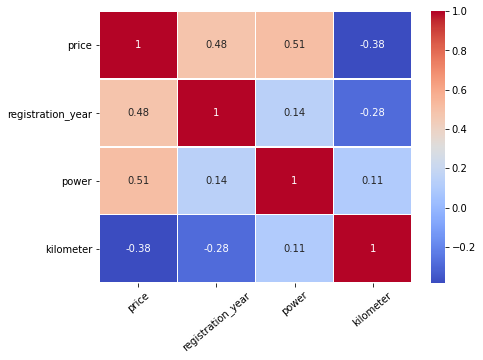

In [46]:
plt.figure(figsize=(7, 5))
sns.heatmap(df.corr(), cmap='coolwarm',  annot=True, linewidths=.2, robust=True)
plt.xticks(rotation=40)
plt.yticks(rotation=0)
plt.show()

Также в результате предобработки мы избавили от лишних столбцов, уменьшив количество признаков с 16 до 10. \
У оставшихся мы изменили регистр заголовков - заменили формат записи в PascalCase приведя к змеиному.

## Обучение моделей

Так как целевая переменная у нас непрерывная, в этом разделе мы будем обучать и тестировать модели линейной регрессии, CatBoostRegressor и LGBMRegressor. \
Сначала мы подготовим выборки для всех трех моделей:
1. Разделим на обучающие и тестовые выборки таргета и признаков.
2. Масштабируем числовые признаки и закодируем категориальные для обучения модели линейной регрессии.
3. Для модели LGBMRegressor заменим тип категориальных колонок на 'category'

### Подготовка обучающих и валидационных выборок

In [47]:
target_train, target_test, features_train, features_test = train_test_split(
    df['price'], df.drop('price', axis=1), test_size=0.40, random_state=RANDOM_STATE
)
target_valid, target_test, features_valid, features_test = train_test_split(
    target_test, features_test, test_size=0.50, random_state=RANDOM_STATE
)

print(f'Размер обучающей выборки признаков - {features_train.shape}.')
print(f'Размер валидационной выборки признаков - {features_valid.shape}.')
print(f'Размер тестовой выборки признаков - {features_test.shape}.')

Размер обучающей выборки признаков - (187455, 9).
Размер валидационной выборки признаков - (62485, 9).
Размер тестовой выборки признаков - (62486, 9).


#### Масштабирование и кодирование признаков для линейной регрессии

Подготовим выборку.

In [48]:
# копируем выборки
features_train_lreg, features_valid_lreg = features_train.copy(), features_valid.copy()

# выделим в отдельную переменную категориальные и числовые признаки
cat_columns = features_train_lreg.select_dtypes(include='object').columns.to_list()
num_columns = features_train_lreg.select_dtypes(include=['int', 'float']).columns.to_list()

print(f'Категориальные колонки: {", ".join(cat_columns)}\nЧисловые колонки: {", ".join(num_columns)}')

Категориальные колонки: vehicle_type, gearbox, model, fuel_type, brand, repaired
Числовые колонки: registration_year, power, kilometer


##### Масштабирование числовых признаков

In [49]:
# создадим экземпляр скалера
scaler = StandardScaler()

# обучим на тестовой выборке
scaler.fit(features_train_lreg[num_columns])

# стандартизируем числовые колонки
features_train_lreg[num_columns] =  scaler.transform(features_train_lreg[num_columns])
features_valid_lreg[num_columns] =  scaler.transform(features_valid_lreg[num_columns])

# оценим результат
features_valid_lreg.sample(5)

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
86071,sedan,0.04,manual,0.51,vectra,-1.60,petrol,opel,no
270068,sedan,-0.73,manual,-0.35,golf,0.58,petrol,volkswagen,no
343368,small,-0.42,manual,-1.52,seicento,-2.15,petrol,fiat,no
80226,small,-0.73,manual,-1.13,polo,0.58,petrol,volkswagen,no
94576,suv,-0.27,manual,0.04,defender,0.58,gasoline,land_rover,no


##### Кодирование категориальных признаков

In [50]:
# настроим энкодер
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist', sparse=False)

# обучим энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(features_train_lreg[cat_columns])

# добавляем ohe-колонки
features_train_lreg[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train_lreg[cat_columns])
features_valid_lreg[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_valid_lreg[cat_columns])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train_lreg = features_train_lreg.drop(cat_columns, axis=1)
features_valid_lreg = features_valid_lreg.drop(cat_columns, axis=1)

# проверим 
features_train_lreg.sample(5)

,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_unknown,vehicle_type_wagon,gearbox_manual,gearbox_unknown,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,model_3er,model_4_reihe,model_500,model_5_reihe,model_5er,model_601,model_6_reihe,model_6er,model_7er,model_80,model_850,model_90,model_900,model_9000,model_911,model_a1,model_a2,model_a3,model_a4,model_a5,model_a6,model_a8,model_a_klasse,model_accord,model_agila,model_alhambra,model_almera,model_altea,model_amarok,model_antara,model_arosa,model_astra,model_auris,model_avensis,model_aveo,model_aygo,model_b_klasse,model_b_max,model_beetle,model_berlingo,model_bora,model_boxster,model_bravo,model_c1,model_c2,model_c3,model_c4,model_c5,model_c_klasse,model_c_max,model_c_reihe,model_caddy,model_calibra,model_captiva,model_carisma,model_carnival,model_cayenne,model_cc,model_ceed,model_charade,model_cherokee,model_citigo,model_civic,model_cl,model_clio,model_clk,model_clubman,model_colt,model_combo,model_cooper,model_cordoba,model_corolla,model_corsa,model_cr_reihe,model_croma,model_crossfire,model_cuore,model_cx_reihe,model_defender,model_delta,model_discovery,model_doblo,model_ducato,model_duster,model_e_klasse,model_elefantino,model_eos,model_escort,model_espace,model_exeo,model_fabia,model_fiesta,model_focus,model_forester,model_forfour,model_fortwo,model_fox,model_freelander,model_fusion,model_g_klasse,model_galant,model_galaxy,model_getz,model_gl,model_glk,model_golf,model_grand,model_i3,model_i_reihe,model_ibiza,model_impreza,model_insignia,model_jazz,model_jetta,model_jimny,model_juke,model_justy,model_ka,model_kadett,model_kaefer,model_kalina,model_kalos,model_kangoo,model_kappa,model_kuga,model_laguna,model_lancer,model_lanos,model_legacy,model_leon,model_lodgy,model_logan,model_lupo,model_lybra,model_m_klasse,model_m_reihe,model_materia,model_matiz,model_megane,model_meriva,model_micra,model_mii,model_modus,model_mondeo,model_move,model_musa,model_mustang,model_mx_reihe,model_navara,model_niva,model_note,model_nubira,model_octavia,model_omega,model_one,model_other,model_outlander,model_pajero,model_panda,model_passat,model_phaeton,model_picanto,model_polo,model_primera,model_ptcruiser,model_punto,model_q3,model_q5,model_q7,model_qashqai,model_r19,model_range_rover,model_range_rover_sport,model_rangerover,model_rav,model_rio,model_roadster,model_roomster,model_rx_reihe,model_s60,model_s_klasse,model_s_max,model_s_type,model_samara,model_sandero,model_santa,model_scenic,model_scirocco,model_seicento,model_serie_2,model_serie_3,model_sharan,model_signum,model_sirion,model_sl,model_slk,model_sorento,model_spark,model_spider,model_sportage,model_sprinter,model_stilo,model_superb,model_swift,model_terios,model_tigra,model_tiguan,model_toledo,model_touareg,model_touran,model_transit,model_transporter,model_tt,model_tucson,model_twingo,model_unknown,model_up,model_v40,model_v50,model_v60,model_v70,model_v_klasse,model_vectra,model_verso,model_viano,model_vito,model_vivaro,model_voyager,model_wrangler,model_x_reihe,model_x_trail,model_x_type,model_xc_reihe,model_yaris,model_yeti,model_ypsilon,model_z_reihe,model_zafira,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,fuel_type_unknown,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
103771,-0.73,-0.84,0.58,0.00

#### Замена типа категориальных колонок для модели LGBMRegressor

In [51]:
features_train_lgbm, features_valid_lgbm = features_train.copy(), features_valid.copy()

# заменим тип категориальных колонок на 'category'
features_train_lgbm[cat_columns] = features_train_lgbm[cat_columns].astype('category')
features_valid_lgbm[cat_columns] = features_valid_lgbm[cat_columns].astype('category')

# проверим
features_valid_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62485 entries, 186897 to 94262
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   vehicle_type       62485 non-null  category
 1   registration_year  62485 non-null  float64 
 2   gearbox            62485 non-null  category
 3   power              62485 non-null  float64 
 4   model              62485 non-null  category
 5   kilometer          62485 non-null  int64   
 6   fuel_type          62485 non-null  category
 7   brand              62485 non-null  category
 8   repaired           62485 non-null  category
dtypes: category(6), float64(2), int64(1)
memory usage: 2.3 MB


### Линейная регрессия

Обучим модель и измерим RMSE на валидационной выборке.

In [52]:
%%time
model_lreg = LinearRegression()
model_lreg.fit(features_train_lreg, target_train)

CPU times: user 13.2 s, sys: 4.41 s, total: 17.6 s
Wall time: 17.6 s


LinearRegression()

In [53]:
%%time
predict = model_lreg.predict(features_valid_lreg)

CPU times: user 57.8 ms, sys: 14 ms, total: 71.8 ms
Wall time: 80 ms


In [ ]:
rmse_lreg = mean_squared_error(target_valid, predict, squared=False)

f'RMSE для модели линейной регрессии: {rmse_lreg:.2f}'

### LGBMRegressor

Подберем лучшие параметры модели c помощью GridSearchCV.

In [55]:
%%time

model = LGBMRegressor(num_leaves=50)

param_grid = {'max_depth': [2, 5, 10, 20, 25],
              'n_estimators': [20, 25, 50, 100],}

grid_search = GridSearchCV(
    model,
    param_grid,
    cv=3,
    n_jobs = -1,
    scoring = 'neg_mean_squared_error'
)

grid_search.fit(features_train_lgbm, target_train)

CPU times: user 4min 17s, sys: 248 ms, total: 4min 17s
Wall time: 4min 42s


GridSearchCV(cv=3, estimator=LGBMRegressor(num_leaves=50), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 10, 20, 25],
                         'n_estimators': [20, 25, 50, 100]},
             scoring='neg_mean_squared_error')

In [56]:
f'Наилучшие значения параметров: {grid_search.best_params_}'

"Наилучшие значения параметров: {'max_depth': 20, 'n_estimators': 100}"

In [57]:
f'Наилучшая оценка модели: {np.sqrt(-grid_search.best_score_):.2f}'

'Наилучшая оценка модели: 1582.84'

**Обучим модель и измерим RMSE на валидационной выборке.**

In [58]:
%%time

model_light = LGBMRegressor(num_leaves=50,
                            max_depth=20,
                            n_estimators=100)

model_light.fit(features_train_lgbm,
                target_train)

CPU times: user 5.42 s, sys: 0 ns, total: 5.42 s
Wall time: 5.47 s


LGBMRegressor(max_depth=20, num_leaves=50)

In [59]:
%%time
predict = model_light.predict(features_valid_lgbm)

CPU times: user 712 ms, sys: 0 ns, total: 712 ms
Wall time: 710 ms


In [60]:
rmse_light = mean_squared_error(target_valid, predict, squared=False)

f'RMSE для модели LGBMRegressor: {rmse_light:.2f}'

'RMSE для модели LGBMRegressor: 1567.14'

### CatBoost

Подберем лучшие параметры модели c помощью GridSearchCV.

In [61]:
%%time
# не указываем num_leaves, ограничение бибиотеки
model = CatBoostRegressor()

# у CatBoostRegressor ограничение на глубину - 16,
# поэтому изменим список вариантов
param_grid = {'max_depth': [5, 8, 12, 15],
              'n_estimators': [20, 25, 50, 100]}

grid_search = GridSearchCV(
    model,
    param_grid,
    cv=3,
    n_jobs = -1,
    scoring = 'neg_mean_squared_error'
)

grid_search.fit(features_train, target_train, cat_features=cat_columns, verbose=0)

CPU times: user 6min 49s, sys: 52.6 s, total: 7min 41s
Wall time: 8min 13s


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f5e9f3edcd0>,
             n_jobs=-1,
             param_grid={'max_depth': [5, 8, 12, 15],
                         'n_estimators': [20, 25, 50, 100]},
             scoring='neg_mean_squared_error')

In [62]:
f'Наилучшие значения параметров: {grid_search.best_params_}'

"Наилучшие значения параметров: {'max_depth': 12, 'n_estimators': 100}"

In [63]:
f'Наилучшая оценка модели: {np.sqrt(-grid_search.best_score_):.2f}'

'Наилучшая оценка модели: 1596.29'

In [64]:
%%time
model_cat = CatBoostRegressor(max_depth=12, n_estimators=100)

model_cat.fit(features_train, target_train, verbose=0, cat_features=cat_columns)

CPU times: user 15.5 s, sys: 133 ms, total: 15.7 s
Wall time: 16.3 s


In [65]:
%%time
preds = model_cat.predict(features_valid)

CPU times: user 96.6 ms, sys: 464 µs, total: 97 ms
Wall time: 97.5 ms


In [66]:
rmse_cat = mean_squared_error(target_valid, preds, squared=False)

f'RMSE модели CatBoost: {rmse_cat:.2f}'

'RMSE модели CatBoost: 1554.92'

## Анализ моделей

Модели показали следующие результаты:

In [67]:
table = pd.DataFrame(index = ['Линейная регрессия', 'LightGBM', 'Catboost'],
                     columns=['качество предсказания', 'время обучения, сек', 'время предсказания, сек'],
                     data=[[rmse_lreg, 56.7, 0.3],
                           [rmse_light, 7.12, 1],
                           [rmse_cat, 7.5, 0.1]])
table

,качество предсказания,"время обучения, сек","время предсказания, сек"
Линейная регрессия,"2,560.27",56.70,0.30
LightGBM,"1,567.14",7.12,1.00
Catboost,"1,554.92",7.50,0.10


Таким образом, лучшей моделью является Catboost, так как в разы быстрее делает предсказания и показывает лучшую точность.

\* время указано не в реальном, а в процессорном времени (CPU times)

**Протестируем лучшую модель на тестовой выборке**

In [68]:
%%time
preds = model_cat.predict(features_test)

CPU times: user 95.7 ms, sys: 81 µs, total: 95.8 ms
Wall time: 94.8 ms


In [69]:
rmse_cat = mean_squared_error(target_test, preds, squared=False)

f'RMSE модели CatBoost на тестовой выборке: {rmse_cat:.2f}'

'RMSE модели CatBoost на тестовой выборке: 1574.26'

На тестовой выборке модель показывает результат незначительно хуже, чем на валидационной. 

## Вывод

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов, в котором можно быстро узнать рыночную стоимость своего автомобиля. Нам нужно было построить модель для определения стоимости. \
Для сервиса важна скорость и точность предсказания, а также быстрота обучения модели. 

Нам были предоставлены исторические данные: технические характеристики, комплектации и цены автомобилей. \
При работе с данными было выявлено значительное количество пропусков и аномалий, часть из которых нам удалось восстановить и обработать без ущерба для статистической ценности фрейма данных. 

После предобработки нам удалось поднять коррекляцию признаков с околонулевого уровня до примерно 50, что в дальнейшем позволило показать неплохой результат даже модели линейной регрессии, так как мы восстановили связи в данных.

Мы подготовили выборки и обучили 3 модели: линейную регрессию, LightGBM и разработанную Яндексом CatВoost. \
С помощью модели для подбора гиперпараметров GridSearchCV, мы выбрали наилучшие доступные настройки и, обучив модели сделали предсказания на валидационных выборках дополнительно измерив скорость. \
Модели показали следующие результаты:

In [70]:
table

,качество предсказания,"время обучения, сек","время предсказания, сек"
Линейная регрессия,"2,560.27",56.70,0.30
LightGBM,"1,567.14",7.12,1.00
Catboost,"1,554.92",7.50,0.10


Таким образом лучшей моделью оказалась Catboost от Яндекса, помимо лучшей точности она показала феноменально низкую скорость предсказания, что обеспечит точное и быстрое получение рыночной цены автомобиля потенциальными новыми клиентами сервиса.

Чтобы сократить искажения и аномалии в данных, что позволит в дальшейшем еще повысить качество предсказания модели, рекомендуем снять ограничение для указания максимального пробега в 150 тыс. км., так как это ставит в один ряд очень изношенные машины с невысокой стоимостью, и имеющие еще хороший запас прочности средней стоимости автомобили. 

Также советуем поставить рациональное ограничение вариантов выбора годов, которые можно выбрать для указания года регистрации автомобиля, так как в текущей реализации много случаев с указанием года регистрации в диапазоне от 1000 до 9999 лет, что искажает крайне важный для предсказания цены автомобиля параметр - возраст авто. 

Дополнительно рекомендуем обратить внимание на аномалию в указании месяца регистрации автомобиля - в базе данных 13 месяцев, так как исчисление идет от 0 и до 12 включительно. 

В ходе предобработки нами также было замечено значительное количество очень дешевых (до 100 долларов) или бесплатных авто. \
В совокупности с ограничением в 150 тыс км пробега и возможностью не указывать параметр 'была ли машина в ремонте', такие анкеты, без обработки, негативно влияют на точность модели, сдвигая предсказываемую рыночную цену автомобиля вниз, что может негативно отразиться на привлечении новых клиентов, которые будут расстроенных низкой ценой. \
Мы рекомендуем добавить раздел 'бесплатно, в добрые руки', 'за символическую цену', либо маркеры 'на запчасти, утиль', в общем каким-либо способом предложить клиентам маркировать такие предложения, что позволит модели более точно предсказывать рыночную стоимоть авто.